In [1]:
import pandas as pd
import seaborn as sns
from glob import glob
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
import metaprofile_across_regions as mar

In [2]:
# Files
coverage_files = glob('../../../results/Metaprofiles/PAS_Quantseq/separate_replicates/**/*_unsmoothed*.tsv')

# Sample annotation
annot = pd.read_csv('../../../data/general/SampleAnnotation.csv', index_col=0)

# Save to
outpath = '../../../results/Metaprofiles/PAS_Quantseq/plots'
os.makedirs(outpath, exist_ok=True)

# Parameters
sw = 20 # Smoothin window

In [3]:
def smoothDf(df, sw):
    cols = [c for c in df.columns.tolist() if c in ['ciMax', 'ciMin', 'mean']]
    df[cols] = df[cols].rolling(sw, center=True,  win_type='triang', axis=0).mean()\
                    .fillna(axis=0, method='ffill')\
                    .fillna(axis=0, method='bfill')
    return df

In [4]:
# Combine into one table
dfList = []
for f in coverage_files:
    df = pd.read_csv(f, sep='\t')
    df['Group'] = f.split('/')[-2].split('_')[0]
    df['Condition'] = f.split('/')[-2].split('cond-')[-1]
    df['Norm'] = f.split('/')[-1].split('norm-')[-1].split('.')[0]
    dfList.append(df)
dfCombined = pd.concat(dfList)

In [5]:
# Smooth with a desired window
dfCombined = dfCombined.groupby(['Sample', 'Condition', 'Norm', 'Group']).apply(smoothDf, sw=sw)

In [6]:
# Annotate samples
dfCombined = dfCombined.merge(annot, on=['Sample', 'Condition'], how='left')
dfCombined.head()

,mean,ciMax,ciMin,Sample,Position,Group,Condition,Norm,Protein,Experiment
0,0.003357,0.002739,0.003975,KO_C1_Crick1.bed.gz,-200,CONTROL,KO_FCL,by_reg,PABPC1,Crick
1,0.004456,0.003306,0.005607,KO_C1_Crick1.bed.gz,-200,DOWN,KO_FCL,by_reg,PABPC1,Crick
2,0.003426,0.002410,0.004442,KO_C1_Crick1.bed.gz,-200,UP,KO_FCL,by_reg,PABPC1,Crick
3,0.059087,0.047553,0.070622,KO_C1_Crick1.bed.gz,-200,CONTROL,KO_FCL,libsize,PABPC1,Crick
4,0.109121,0.072587,0.145655,KO_C1_Crick1.bed.gz,-200,DOWN,KO_FCL,libsize,PABPC1,Crick


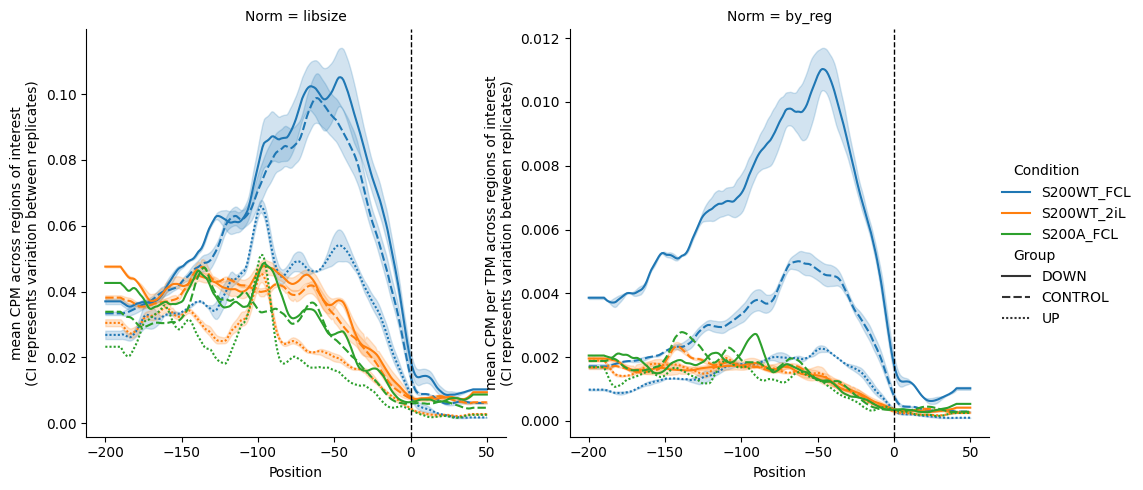

In [7]:
# Plot
# Plot LIN28A aroud PAS in UP / DOWN / CTRL -  libnorm and expr norm side by side
dfPlot = dfCombined.loc[dfCombined.Protein == 'LIN28A']

hue_order = ['S200WT_FCL', 'S200WT_2iL', 'S200A_FCL']
colorMap = {sample: sns.color_palette('tab10', len(hue_order))[i] for i, sample in enumerate(hue_order)}

g = sns.relplot(
    data=dfPlot, x='Position', y='mean', hue='Condition',
    style='Group', kind='line', col='Norm', facet_kws={'sharey': False, 'sharex': True},
    style_order=['DOWN', 'CONTROL', 'UP'], hue_order=['S200WT_FCL', 'S200WT_2iL', 'S200A_FCL'],
    col_order=['libsize', 'by_reg'], palette=colorMap
    )
for idx, ax in g.axes_dict.items():
    ax.axvline(0, color='black', ls='dashed', lw=1)
    if idx == 'libsize':
        ax.set_ylabel('mean CPM across regions of interest\n(CI represents variation between replicates)')
    else:
        ax.set_ylabel('mean CPM per TPM across regions of interest\n(CI represents variation between replicates)')

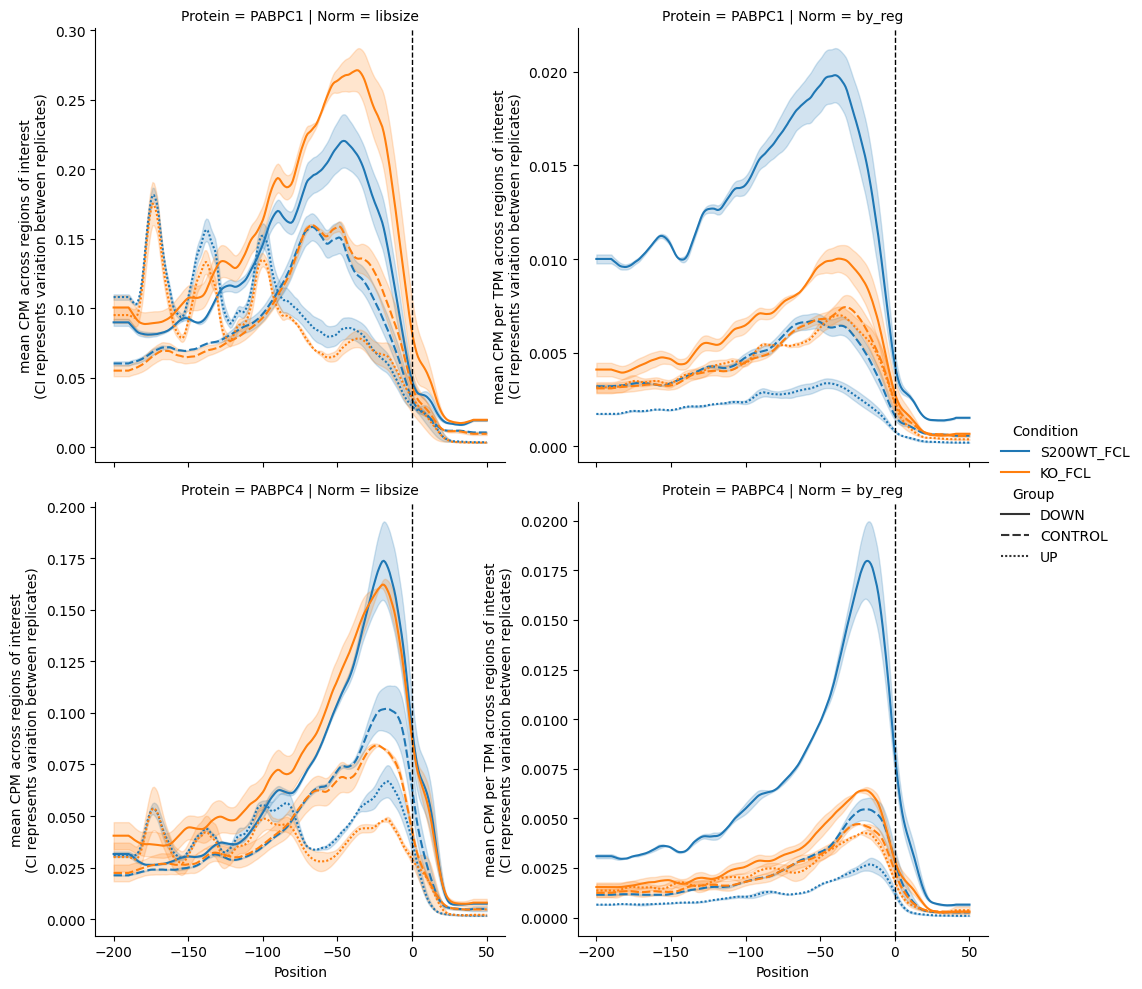

In [9]:
# # Plot PABPC1 and C4 aroud PAS in UP / DOWN / CTRL -  libnorm and expr norm side by side
dfPlot = dfCombined.loc[dfCombined.Protein != 'LIN28A']

hue_order = ['S200WT_FCL', 'KO_FCL']
colorMap = {sample: sns.color_palette('tab10', len(hue_order))[i] for i, sample in enumerate(hue_order)}

g = sns.relplot(
    data=dfPlot, x='Position', y='mean', hue='Condition',
    style='Group', kind='line', col='Norm', row='Protein', facet_kws={'sharey': False, 'sharex': True},
    style_order=['DOWN', 'CONTROL', 'UP'], hue_order=hue_order, col_order=['libsize', 'by_reg'], palette=colorMap
    )
for idx, ax in g.axes_dict.items():
    ax.axvline(0, color='black', ls='dashed', lw=1)
    if idx[-1] == 'libsize':
        ax.set_ylabel('mean CPM across regions of interest\n(CI represents variation between replicates)')
    else:
        ax.set_ylabel('mean CPM per TPM across regions of interest\n(CI represents variation between replicates)')